<a href="https://colab.research.google.com/github/nandakishore2696/Deep_Learning_CX/blob/main/49_Cat_vs_Dog_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogs-vs-cats:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F84954%2F196452%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T100821Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4defc400e825de7cf90d245e6d39715a7a7c7cafcd894e7e70c1771e64ac7a85d14b91bb46662f8049b185305a73516f5cd8eb1bfbd96d9a49d75547fa55dee292982b2abb79fb9963034a9ee298f790b1cd233d1b006a6a29073a56f5ff87fe34bad10f37785937cc5c865de8283feb023a111d6181208f09725f0c658e12314f063d39be73f130c97b3d29b29b2870e5b1c7cc713ca0d10eea5f5304ea6c356df0234e41378d9cad05b65d5bd8dc66d26f5fce7e69ef6d374f0f8e7fbcfa1498ba33fda9ff6a18206bf7c36ed3832f7273f5d76e3347e75d10becfdc7efa56539e1f0d454d723250785ad44795f53a70377b3461206094369fc21020547064'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1142891694 bytes downloaded
Downloaded and uncompressed: dogs-vs-cats
Data source import complete.


In [15]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import matplotlib.pyplot as plt

In [3]:
#Generator
train_ds=keras.utils.image_dataset_from_directory(
directory='/kaggle/input/dogs-vs-cats/train',
labels='inferred',
label_mode='int',
batch_size=32,
image_size=(256,256)
)

validation_ds=keras.utils.image_dataset_from_directory(
directory='/kaggle/input/dogs-vs-cats/test',
labels='inferred',
label_mode='int',
batch_size=32,
image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [4]:
# Normalize
def process(image,label):
  image = tf.cast(image/255.,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [6]:
# create CNN Model

model =Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

In [ ]:
plt.plot(history.history['acuracy'], color='red', label='train')
plt.plot(history.history['val_acuracy'], color='blue', label='Valodation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='Valodation')
plt.legend()
plt.show()

# Ways to reduce overfitting
* Add more data
* Data Augmentation
* L1/L2 Regularization
* Dropout
* Batch Norm
* Reduce Complxity

# Dropout

In [ ]:
# create CNN Model

model =Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

In [ ]:
plt.plot(history.history['acuracy'], color='red', label='train')
plt.plot(history.history['val_acuracy'], color='blue', label='Valodation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='Valodation')
plt.legend()
plt.show()

* test

In [12]:
import cv2

In [13]:
test_img = cv2.imread('/content/dog.jpg')

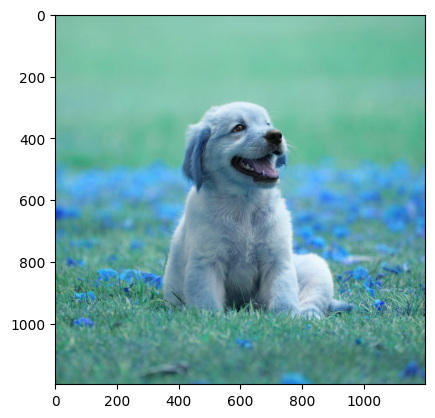

In [16]:
plt.imshow(test_img)

In [17]:
test_img.shape

(1197, 1200, 3)

In [18]:
test_img = cv2.resize(test_img,(256,256))

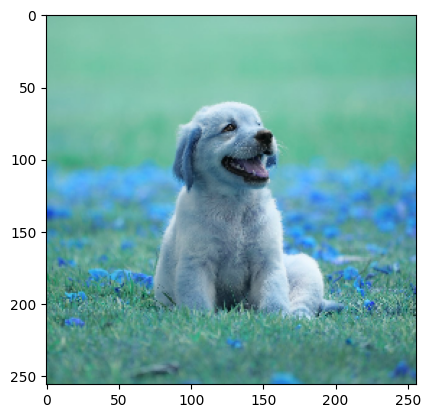

In [19]:
plt.imshow(test_img)

In [20]:
test_img.shape

(256, 256, 3)

In [21]:
test_input = test_img.reshape(1,256,256,3)

In [ ]:
model.predict(test_input)

In [22]:
test_img = cv2.imread('/content/cat.jpg')

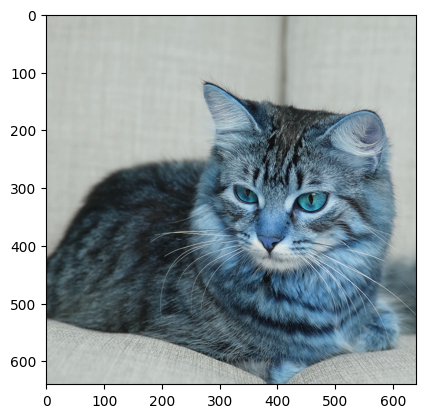

In [23]:
plt.imshow(test_img)

In [ ]:
test_img.shape

In [ ]:
test_img = cv2.resize(test_img,(256,256))

In [ ]:
test_img.shape

In [ ]:
test_input = test_img.reshape(1,256,256,3)

In [ ]:
model.predict(test_input)